## Unit 3, Lesson 2, Project5 - Random forest: guided example

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#data source:https://www.lendingclub.com/info/download-data.action, this contains 2015 loan data only
PATH = 'https://drive.google.com/open?id=1VJa2ycHYxC1yuyv4tJlxZcwrJBVIPWPb'
PATH2 = 'https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1'
y2015 = pd.read_csv(PATH2, 
                    skipinitialspace=True, 
                    header=1, 
                    error_bad_lines=False)

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


## The Blind Approach
In this approach, we will just throw everything we got with no thought to RF through sklearn. With sklearn, all the independent variables must be numeric, so we will use `get_dummies` from pandas to replace every categorical column in our data. Let's see what happen with such a naive approach.

In [4]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
rfc = ensemble.RandomForestClassifier()

#create the dependent variables data
X = y2015.drop('loan_status', 1)

#create the outcome variable data
Y = y2015['loan_status']

#create dummies for all the categorical variables in X, dummies creates 1 hot code for the categories in a variable

#X = pd.get_dummies(X)
#cross_val_score(rfc, X, Y, cv=5)

##### Running the `get_dummies` line or the `cross_val_score` line will kill the kernel, our data has about 400,000 rows, if there's a typo in any row of a categorical cols. the `get_dummies` line will pick that row as a different category therby creating a huge number of columns beyong which the kernel can handle thereby killing it. See demo for dummies usage below:

In [20]:
test = {'first':list('acbabacaab'),
        'second':list('dfeefdefde'),
        'third':list('ghigiihggh')
}
dummy_test = pd.get_dummies(pd.DataFrame(test))
dummy_test

,first_a,first_b,first_c,second_d,second_e,second_f,third_g,third_h,third_i
0,1,0,0,1,0,0,1,0,0
1,0,0,1,0,0,1,0,1,0
2,0,1,0,0,1,0,0,0,1
3,1,0,0,0,1,0,1,0,0
4,0,1,0,0,0,1,0,0,1
5,1,0,0,1,0,0,0,0,1
6,0,0,1,0,1,0,0,1,0
7,1,0,0,0,0,1,1,0,0
8,1,0,0,1,0,0,1,0,0
9,0,1,0,0,1,0,0,1,0


## Data Cleaning

First to fix the `get_dummies` issues, lets look at all our categorical variables and see how many distinct counts there are...

In [6]:
#let's see the number of unique values in each categorical variable
categorical = y2015.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

id
421097
term
2
int_rate
110
grade
7
sub_grade
35
emp_title
120812
emp_length
11
home_ownership
4
verification_status
3
issue_d
12
loan_status
7
pymnt_plan
1
url
421095
desc
34
purpose
14
title
27
zip_code
914
addr_state
49
earliest_cr_line
668
revol_util
1211
initial_list_status
2
last_pymnt_d
25
next_pymnt_d
4
last_credit_pull_d
26
application_type
2
verification_status_joint
3


**As we can see from this print out, some of these categories have a hundred thousand unique types( that killed the kernel). We have 12 variables with more than 30 categories. We will convert `id` and `int_rate`to numerical(as this makes sense) and we'll and drop others. In doing this there's a lot of code that gets written to just see if the numeric conversion makes sense. It's a manual process that we'll abstract away and just include the conversion. You could extract numeric features from the dates, but here we'll just drop them. There's a lot of data, it shouldn't be a huge problem.**

In [7]:
# Convert ID and Interest Rate to numeric. 
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

In [8]:
#This is how to_numeric works, here it is converting string 2015 to numeric
xx = '2015'
pd.to_numeric(xx, errors='coerce')

2015

Wonder what was causing the dtype error on the id column, which should have all been integers? Let's look at the end of the file.

In [9]:
y2015.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
421092,36271333.0,38982739.0,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,5 years,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,36490806.0,39222577.0,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,1 year,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,36271262.0,38982659.0,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,10+ years,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
#Remove two summary rows at the end that don't actually contain data.
y2015 = y2015[: -2] #select all rows except the last 2

In [18]:
y2015.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
421088,36221446.0,38932858.0,11575.0,11575.0,11575.0,36 months,15.59,404.61,D,10+ years,...,0.0,1.0,100.0,42.9,0.0,0.0,29866.0,19798.0,27500.0,1766.0
421089,36330911.0,39042282.0,12000.0,12000.0,12000.0,36 months,11.99,398.52,B,< 1 year,...,1.0,3.0,98.3,50.0,0.0,0.0,325484.0,112990.0,15400.0,98125.0
421090,36371250.0,39102635.0,10000.0,10000.0,10000.0,36 months,11.99,332.10,B,8 years,...,0.0,1.0,100.0,100.0,0.0,0.0,32950.0,25274.0,9200.0,15850.0
421091,36441262.0,39152692.0,24000.0,24000.0,24000.0,36 months,11.99,797.03,B,10+ years,...,0.0,2.0,56.5,100.0,0.0,0.0,152650.0,8621.0,9000.0,0.0
421092,36271333.0,38982739.0,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,5 years,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0


**Now this should be better. Let's try again `get_dummies` again**

In [19]:
pd.get_dummies(y2015)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,last_credit_pull_d_Nov-2016,last_credit_pull_d_Oct-2015,last_credit_pull_d_Oct-2016,last_credit_pull_d_Sep-2015,last_credit_pull_d_Sep-2016,application_type_INDIVIDUAL,application_type_JOINT,verification_status_joint_Not Verified,verification_status_joint_Source Verified,verification_status_joint_Verified
0,68009401.0,72868139.0,16000.0,16000.0,16000.0,14.85,379.39,48000.0,33.18,0.0,...,0,0,0,0,0,1,0,0,0,0
1,68354783.0,73244544.0,9600.0,9600.0,9600.0,7.49,298.58,60000.0,22.44,0.0,...,0,0,0,0,0,1,0,0,0,0
2,68466916.0,73356753.0,25000.0,25000.0,25000.0,7.49,777.55,109000.0,26.02,0.0,...,0,0,0,0,0,1,0,0,0,0
3,68466961.0,73356799.0,28000.0,28000.0,28000.0,6.49,858.05,92000.0,21.60,0.0,...,0,0,0,0,0,1,0,0,0,0
4,68495092.0,73384866.0,8650.0,8650.0,8650.0,19.89,320.99,55000.0,25.49,0.0,...,0,0,0,0,0,1,0,0,0,0
5,68506798.0,73396623.0,23000.0,23000.0,23000.0,8.49,471.77,64000.0,18.28,0.0,...,0,0,0,0,0,1,0,0,0,0
6,68566886.0,73456723.0,29900.0,29900.0,29900.0,12.88,678.49,65000.0,21.77,0.0,...,0,0,0,0,0,1,0,0,0,0
7,68577849.0,73467703.0,18000.0,18000.0,18000.0,11.99,400.31,112000.0,8.68,0.0,...,0,0,0,0,0,1,0,0,0,0
8,66310712.0,71035433.0,35000.0,35000.0,35000.0,14.85,829.90,110000.0,17.06,0.0,...,0,0,0,0,0,1,0,0,0,0
9,68476807.0,73366655.0,10400.0,10400.0,10400.0,22.45,289.91,104433.0,25.37,1.0,...,0,0,0,0,0,1,0,0,0,0


It finally works! We had to sacrifice sub grade, state address and description, but that's fine. If you want to include them you could run the dummies independently and then append them back to the dataframe.

## Second Attempt

Now let's try to run this model the second time.

We're also going to drop NA columns, rather than impute, because our data is rich enough that we can probably get away with it.

This model may take a few minutes to run.

In [22]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10)

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.

array([0.9797915 , 0.98043267, 0.98159626, 0.98176205, 0.97005462,
       0.97791498, 0.93554822, 0.980835  , 0.97976583, 0.9801216 ])

The score cross validation reports is the accuracy of the tree. Here we're about 98% accurate.

That works pretty well, but there are a few potential problems. Firstly, we didn't really do much in the way of feature selection or model refinement. As such there are a lot of features in there that we don't really need. Some of them are actually quite impressively useless.

There's also some variance in the scores. The fact that one gave us only 93% accuracy while others gave higher than 98 is concerning. This variance could be corrected by increasing the number of estimators. That will make it take even longer to run, however, and it is already quite slow.

## DRILL: Third Attempt

So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

## Solution

#### first let try feature assesment with correllation matrix and heat map.

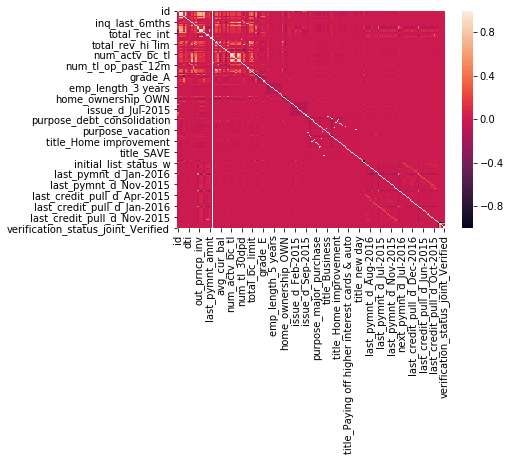

In [26]:
#genrate correllation matrix and plot heat map for X
import seaborn as sns
ax = sns.heatmap(X.corr())

#### This isn't working, let's use PCA to resolve the components then. Before this, we know that PCA performs better with normalised data, we will normalise our data first.

In [81]:
from sklearn.preprocessing import StandardScaler
import numpy as np
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [83]:
#since scaler ussually returns array, let's convert back to df and append X's header
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [132]:
#let's now apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=131)
X_scale_components = pca.fit_transform(X_scaled)
pd.DataFrame(X_scale_components)

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,130
0,3.867057,2.671855,-3.081348,2.930631,-1.741075,2.057014,0.975598,-1.143005,1.353144,-3.187171,...,0.124094,-0.271227,-0.726692,-1.345326,-0.816678,0.438486,1.583596,-2.019763,1.306993,0.153758
1,-3.276565,0.168672,-2.272389,3.181357,-0.668797,2.046183,1.111414,-1.230841,0.703155,0.843728,...,-0.103340,-0.268137,-0.265513,0.449656,0.300190,-0.304354,0.589563,-0.796076,0.657150,0.139246
2,2.562338,-4.149617,1.671229,3.544820,0.309294,-0.764043,3.920363,-1.887156,-0.742865,0.294070,...,0.350215,0.081746,-1.157637,-0.390528,0.200865,-0.715379,-0.712321,-0.615695,1.257794,0.015617
3,4.190847,0.562695,-2.971966,2.319239,-1.114823,-1.677356,3.160188,-1.108547,0.877424,-1.442296,...,-0.155104,-0.165458,0.204758,0.465261,0.364071,-0.377619,0.036909,0.015598,0.005823,-0.049269
4,-0.337956,4.030267,5.315879,-3.934186,1.070646,2.649879,3.499501,-3.055833,-1.841872,-0.448512,...,-2.034162,2.833830,-1.455939,0.519641,0.288669,2.212463,2.206953,0.765093,-2.197050,0.575254
5,2.065290,2.421325,-3.094775,0.471710,-2.165176,2.843359,0.900371,-1.534937,0.699015,1.494354,...,0.022977,0.102131,0.141910,-0.132154,-0.117473,0.301021,-0.131266,0.145087,-0.109478,-0.033253
6,3.663818,-0.442937,-3.839928,-1.994957,0.988748,0.289007,1.997467,-1.601271,0.573741,-0.830091,...,-0.083410,-0.195645,0.115427,-0.871123,-0.863249,1.231385,0.406854,-0.334236,-0.304203,-0.077204
7,3.584678,0.554093,2.355981,1.225731,0.333875,-0.076214,3.606204,-2.089376,0.198890,-1.619588,...,2.395997,-0.246348,-1.235348,-1.343476,1.441952,0.159062,-0.341089,-1.686049,0.296162,1.556771
8,4.600026,-2.019372,-4.430470,-1.684505,-0.151826,0.127936,2.155547,-1.645618,1.064586,-1.407441,...,-0.079818,-0.369514,-0.304034,-0.893606,-1.100716,-0.640713,0.875390,-0.640131,-0.068971,-0.129088
9,1.433676,0.169172,1.674298,0.049154,3.937462,3.937206,0.393036,-2.262065,-0.523163,0.173058,...,1.655134,0.200724,-0.164577,0.775048,1.031199,-0.222669,-0.442069,0.632972,-1.144208,0.064991


In [140]:
#we will find out how many components we need to keep to have 95% variance explained.
def optimun_no_comp(explained_variance):
    cumsum = 0
    i = 0
    while cumsum<=0.95:
        cumsum+=explained_variance[i]
        i+=1
    return(i)

#optimun_no_comp(pca.explained_variance_ratio_)

#### So we need to keep 131 components to have 95% of variance in our data explined. In this solution I had started out without stating any value for n-component while creating the PCA object thereby ensuring that all components were captured in the PCA. After getting that result, I then defined the above function to calculate the optimum number of components needed via the cummumlation sum of the explained variance. I then went back to declear that number of components in the PCA.

In [142]:


cross_val_score(rfc, X_scale_components, Y, cv=10)

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.

array([0.95291017, 0.95438247, 0.95689962, 0.95711232, 0.93666588,
       0.95138922, 0.94863331, 0.95366676, 0.94559099, 0.95069586])

##### This result looks good. After dropping more than 50% of the data via PCA accuray is still way above 90%. We can also see a reduced variance in this result compare to our second attempt where accurary ranged from 98 to 93%. To answer the last question of what happens without using anything related to payment amount or outstanding principal, I could takeout those components prior to running PCA.